# Rede Neural Multilayer perceptron

$\bf{Aluno}$: Danilo Alves Oliveira

## Questão 1
Considere o conjunto de dados disponível em concrete.csv, organizado em 9 colunas, sendo as 8 primeiras colunas os atributos e a última coluna a saída. Os 8 atributos referem-se à caracterização de diferentes tipos de concreto para construção civil. A saída é a resistência à compressão do concreto (em megapascals, MPa). Maiores detalhes sobre os dados podem ser conferidos em https://www.openml.org/d/4353.

a) Considere um modelo de regressão não linear baseado em redes neurais artifíciais. Separe os dados aleatoriamente em treino, validação e teste (por exemplo, 60%, 20% e 20%). Nesse cenário, treine e avalie o modelo abaixo:

- MLP (multilayer perceptron): 1 camada oculta e treinamento
  em minibatch via gradiente descendente estocástico com termo de
  momentum. Utilize o conjunto de validação para ajustar os hiperparâmetros.
  
b) Apresente as curvas da função custo nos conjuntos de treinamento e validação ao longo das épocas. Reporte também para os conjuntos de treino, validação e teste as métricas de RMSE, MAE e MRE.

In [67]:
# importando as bibliotecas e lendo o dataset
import numpy as np
import random
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

dataset = np.genfromtxt('./concrete.csv', delimiter=',')

### Funções
As funções utilizadas para as duas questões são apresentadas a seguir, são divididas em "funções de pré-processamento", "funções de métricas", "funções de ativação" e "Classe da rede neural". A função de pré-processamento é para incrementar os valores 1 do bias nos arrays de dados. As funções de métricas consistem de funções para cálculo de métricas, uma específica para a regressão (com as métricas RMSE, MAE e MRE) e as demais para a classificação (acurácia e cross-entropy). As funções de ativação são as funções utilizadas nos neurônios da rede, foram implementadas alguns tipos como relu, tangente hiperbólica, sigmoide, softmax e identidade. Também foram implementadas as derivadas das funções utilizadas na camada oculta. A classe da rede neural consiste de uma classe com os parâmetros da rede e algumas funções pertinentes a seu funcionamento.

In [95]:
# === Funções de pré-processamento dos dados === #

# função para adicionar colunas de 1
def addOneColunm(x):
    return np.c_[np.ones(x.shape[0]), x[:, :]]

# === Funções de métricas === #

def metricsReg(y, y_pred):
    RMSE = np.sqrt(np.mean((y - y_pred)**2))
    MAE = np.mean(np.abs(y - y_pred))
    MRE = np.mean(np.abs((y - y_pred)/y))
    
    return RMSE, MAE, MRE

# função para calcular a acurácia
def accuracy(y, y_pred):
    a = np.count_nonzero((y == y_pred) == True)
    
    return a/len(y) * 100

# função para calcular a cross-entropy
def crossEntropy(y, pred_val):
    return  -np.mean(np.sum(y * np.log(pred_val), axis=1))

# === Funções de ativação === #

# função linear
def linear(x):
    return x

# função ReLU
def reLU(x):
    out = []
    out.append(np.array([max(0, u) for u in x[0]]))
    for i in range(1,x.shape[0]):
        out.append(np.array([max(0, u) for u in x[i]]))
    return np.array(out)

# função derivada da ReLU
def deri_reLU(x):
    out = []
    out.append([1 if u>=0 else 0 for u in x[0]])
    for i in range(1,x.shape[0]):
        out.append([1 if u>=0 else 0 for u in x[i]])
    return np.array(out)

# função da sigmoide
def fsigmoide(x):
    return 1/(1+np.exp(-x))

# função da tangente hiperbólica
def ftangh(x):
    return (np.exp(2*x)-1)/(np.exp(2*x)+1)

# função para aplicar a sigmoide no array u
def sigmoide(x):
    out = []
    out.append(np.array([fsigmoide(u) for u in x[0]]))
    for i in range(1,x.shape[0]):
        out.append(np.array([fsigmoide(u) for u in x[i]]))
    return np.array(out)

# função para aplicar a derivada da sigmoide no array u
def deri_sigmoide(x):
    out = []
    out.append([fsigmoide(u) - fsigmoide(u)**2 for u in x[0]])
    for i in range(1,x.shape[0]):
        out.append([fsigmoide(u) - fsigmoide(u)**2 for u in x[i]])
    return np.array(out)

# função para aplicar a tangente hiperbólica no array u
def tangh(x):
    out = []
    out.append(np.array([ftangh(u) for u in x[0]]))
    for i in range(1,x.shape[0]):
        out.append(np.array([ftangh(u) for u in x[i]]))
    return np.array(out)

# função para aplicar a derivada da tangente hiperbólica no array u
def deri_tangh(x):
    out = []
    out.append([1 - ftangh(u)**2 for u in x[0]])
    for i in range(1,x.shape[0]):
        out.append([1 - ftangh(u)**2 for u in x[i]])
    return np.array(out)

# função da softmax
def fsoftmax(x):
    num = np.exp(x)
    return num/np.sum(num)

# função para aplicar a softmax array r
def softmax(x, N):
    o1 = []
    for j in range(N):
        out = []
        for outNeur in x:
            out.append(outNeur[j])

        o1.append(fsoftmax(out))
    return np.array(o1)

# === Classe da Rede Neural === #

class NeuralNetwork:
    
    def __init__(self, Nh, dims, alpha, momentum, hiddenFunc, outFunc):
        
        self.Nh = Nh
        self.alpha = alpha
        self.M_delta = 0
        self.W_delta = 0
        self.momentum = momentum
        self.hiddenFunc = hiddenFunc
        self.outFunc = outFunc
        
        # inicialização baseada na Xavier
        self.W = np.zeros([Nh, dims])
        for j in range(Nh):
            self.W[j,:] = initBXavier(dims)

        self.M = np.zeros([K, Nh+1])
        for j in range(K):
            self.M[j,:] = initBXavier(Nh+1)
    
    # função para inicialização baseada em Xavier
    def initBXavier(self, size):
        w = np.array([np.random.normal(0, np.sqrt(1/size)) for x in range(size)])
        w[0] = 0.01 # bias

        return w
    
    def forward(self, batch_X):
        u = self.W@batch_X.T
        
        if self.hiddenFunc == 'tangh':
            z = tangh(u)
        elif self.hiddenFunc == 'sigmoide':
            z = sigmoide(u)
        elif self.hiddenFunc == 'relu':
            z = reLU(u)

        # monta vetor de saída da camada oculta, adicionando o bias
        z = np.r_[np.ones([1, batch_X.shape[0]]), z]

        #camada de saida
        r = self.M@z
        
        # função de saida
        if self.outFunc == 'identidade':
            o1 = linear(r)
        elif self.outFunc == 'softmax':
            o1 = softmax(r, r.shape[1])

        # salva os valores para serem usados caso seja utilizado o backward
        self.u = u
        self.z = z
        
        return o1

    def backward(self, e, batch_X, mode):

        delta = -e
        
        if self.hiddenFunc == 'tangh':
            deri_u = deri_tangh(self.u)
        elif self.hiddenFunc == 'sigmoide':
            deri_u = deri_sigmoide(self.u)
        elif self.hiddenFunc == 'relu':
            deri_u = deri_reLU(self.u)
        
        if mode == "classification":
            delta = delta.T
            C = deri_u * (self.M[:, 1:self.Nh+1].T @ delta)
        else:
            delta = delta.reshape(1,-1)
            C = deri_u*(np.expand_dims(self.M[0][1:self.Nh+1], axis=0).T @ delta)

        #atualização
        self.M_delta = self.momentum*self.M_delta - self.alpha * delta @ self.z.T
        self.M = self.M + self.M_delta
                
        self.W_delta = self.momentum*self.W_delta - self.alpha * C @ batch_X
        self.W = self.W + self.W_delta

### Pré-processamento
Inicialmente os dados são separados do dataset em entradas X e saídas y, após isso os dados são separados em 80% para a etapa de treino e 20% para a de teste. Os dados de treino são separados novamente para obter o grupo de validação, são separados 25% dos 80% de treino, para poder corresponder a 20% do dataset completo como pede a questão. Na célula seguinte, os dados de X_train, X_val e y_train são normalizados pela função StandardScaler do pacote sklearn, ela padroniza as características subtraíndo a média e escalonando para a variância da unidade. Por fim, são adicionadas as colunas de 1 dos bias nos arrays de entrada da rede.

In [31]:
# Separa nos vetores de entrada e saída
X = dataset[:, 0:8]
y = dataset[:, dataset.shape[1]-1]

# separa em 80% para treino e 20% para teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12345)

# retira 20% das amostras do treino para a validação, como é porcentagem de porcentagem = 0.25 x 0.8 = 0.2
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=12345)

print(f'Sizes: \nX_train: {len(X_train)} X_test: {len(X_test)} X_val: {len(X_val)} total: {len(X)}')

Sizes: 
X_train: 618 X_test: 206 X_val: 206 total: 1030


In [43]:
# obtem as escalas para normalizar
X_scale = StandardScaler().fit(X_train)
y_scale = StandardScaler().fit(y_train[:,None])

# Normaliza os dados de treino
X_train_norm = X_scale.transform(X_train)
y_train_norm = y_scale.transform(y_train[:,None])

# Normaliza as validações
X_val_norm = X_scale.transform(X_val)

# Adiciona coluna de 1
X_train_norm = addOneColunm(X_train_norm)
X_val_norm = addOneColunm(X_val_norm)

### Treinamento com Random-search
Inicia o processo de treinamento da rede com random-search para selecionar combinações aleatórias dos hiperparâmetros do número de neurônios e taxa de aprendizagem. Nessa implementação, foram fixados alguns hiperparâmetros como, tamanho do batch de 32, momentum de 0.9 e 200 épocas. As funções de ativação utilizadas são a tangente hiperbólica para a camada oculta, para fazer o mapeamento não-linear nos dados, e a identidade para a camada de saída, por se tratar de um problema de regressão não precisa de transformação de saída. No random-search são testadas 9 combinações, a combinação de 3 valores de número de neurônios e 3 valores da taxa de aprendizagem. A rede é treinada por SGD realizando permutações aleatórias no dados a cada época e atualizando os pesos por batchs. Ao final do treinamento de cada combinação do random-search são armazenadas as curvas de treino e validação, as métricas de validação e a RMSE de validação da última época. O array com essas RMSE's é utilizado para descobrir qual a combinação com melhores resultados de validação, baseado na posição do array com menor RMSE. Em seguida são apresentados os gráficos da curva de aprendizagem e dos valores da RMSE de validação a cada iteração do random-search. O gráfico da curva de aprendizagem apresentado é obtido por meio da combinação de hiperparâmetros com menor valor de RMSE de validação. O gráfico das iterações do random-seach apresentam as RMSE's de validação armazenadas a cada combinação de hiperparâmetros e marca com um circulo vermelho a combinação com menor RMSE.

Step: 0
Step: 600
Step: 1200
Time: 3317.637999534607

 hyperparameters of lower validation by random-search:
 N: 96 lr: 0.0009499999999999999

Metrics of lower validation set:
RMSE: 3.363326288203086
MAE: 2.6589071731741813 
MRE: 10.190600958603117% 



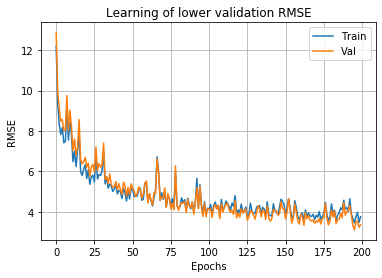

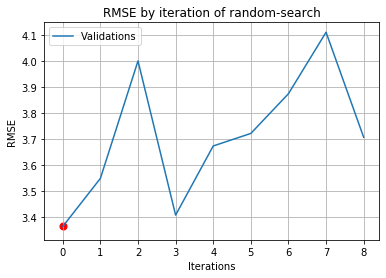

In [60]:
# tamanho do batch, épocas
batch_size = 32
epochs = 200
K = 1 # neurônios de saída
mi = 0.9

# para armazenar a melhor validação de cada combinação do random search
rmse_validations = []

# para armazenar as curvas e metricas ao longo do random search
history_rmse_val = []
history_rmse_train = []
metrics_val = []

# seleciona valóres aleatórios para o random search
random_neurons = random.sample(range(50,130), 3)
random_leaning = random.sample(list(np.linspace(0.00001, 0.001, 100)), 3)

# iteração do random search
step=0

start = time.time()

# para cada quantidade de neurônio da lista
for Nh in random_neurons:
    
    print(f'Step: {step}')
    
    # para cada taxa de aprendizagem da lista
    for alpha in random_leaning:
        
        rmse_erros_train = []
        rmse_erros_val = []

        # criar rede neural
        net = NeuralNetwork(Nh, X_train_norm.shape[1], alpha, mi, hiddenFunc='tangh', outFunc='identidade')

        # iterações
        for i in range(0, epochs):

            # Permuta dos dados de treino
            indices = np.random.permutation(X_train_norm.shape[0])

            # Percorre todos os elementos em lotes
            for j in range(0,len(indices),batch_size):

                if j+batch_size <= len(X_train_norm):
                    batch_X = X_train_norm[indices[j:j+batch_size],:]
                    batch_y = y_train_norm[indices[j:j+batch_size]]
                else:
                    batch_X = X_train_norm[indices[j:],:]
                    batch_y = y_train_norm[indices[j:]] 

                # forward
                o1 = net.forward(batch_X)
                
                # erro
                e = (batch_y - o1.reshape(-1,1))

                # backward
                net.backward(e, batch_X)
            
            # Realiza a predição de treino e cálcula as métricas
            y_pred = net.forward(X_train_norm)
            y_pred = y_scale.inverse_transform(y_pred)
            
            RMSE_train, MAE_train, MRE_train = metricsReg(y_train, y_pred)
            rmse_erros_train.append(RMSE_train)
            
            #Realiza a predição de validação e cálcula as métricas
            y_pred = net.forward(X_val_norm)
            y_pred = y_scale.inverse_transform(y_pred)

            RMSE_val, MAE_val, MRE_val = metricsReg(y_val, y_pred)
            rmse_erros_val.append(RMSE_val)
            
        
        # armazena as informações dessa combinação do random-search
        rmse_validations.append(RMSE_val) # a validação a ser considerada é a ultima das épocas
        history_rmse_train.append(rmse_erros_train)
        history_rmse_val.append(rmse_erros_val)
        metrics_val.append((RMSE_val, MAE_val, MRE_val))
        step+=1
        
        

end = time.time()
print(f'Time: {end - start}')

# Obtem combinação de hiperparâmetros com menor RMSE de validação
mini = np.min(rmse_validations)

index = rmse_validations.index(mini)
p_neur = int(index/len(random_neurons))
p_lr = index - int(index/len(random_leaning)) * len(random_leaning)

print(f'\n hyperparameters of lower validation by random-search:\n N: {random_neurons[p_neur]} lr: {random_leaning[p_lr]}\n')

print(f'Metrics of lower validation set:\nRMSE: {metrics_val[index][0]}\nMAE: {metrics_val[index][1]} \nMRE: {metrics_val[index][2]*100}% \n')

# Plotagem das curvas obtidas com a melhor combinação de hiperparâmetros
plt.plot(range(len(history_rmse_train[index])), history_rmse_train[index], label='Train')
plt.plot(range(len(history_rmse_val[index])), history_rmse_val[index], label='Val')
plt.title('Learning of lower validation RMSE')
plt.xlabel("Epochs")
plt.ylabel("RMSE")   
plt.grid(True)
plt.legend()
plt.show()

# Plotagem dos resultados do random-search
plt.plot(range(len(rmse_validations)), rmse_validations, label='Validations')
plt.scatter(index, rmse_validations[index], s=50, c='red') # marca menor valor
plt.title('RMSE by iteration of random-search')
plt.xlabel("Iterations")
plt.ylabel("RMSE")   
plt.grid(True)
plt.legend()
plt.show()   



### Retreinamento 
Une os grupos de treino e validação para realizar o treinamento novamento com os melhores hiperparâmetros obtidos no processo anterior. Nesse processo, são calculadas as métricas para o grupo de treino e teste e apresentadas ao final juntos com o de validação de menor RMSE da etapa anterior.

In [36]:

# Une os grupos de treino e validação
X_train = np.r_[X_train, X_val]
y_train = np.r_[y_train, y_val]

print(f'Sizes: \nX_train: {len(X_train)} X_test: {len(X_test)} X_val: {len(X_val)} total: {len(X)}')

X_scale = StandardScaler().fit(X_train)
y_scale = StandardScaler().fit(y_train[:,None])

X_train_norm = X_scale.transform(X_train)
y_train_norm = y_scale.transform(y_train[:,None])

X_test_norm = X_scale.transform(X_test)

# Adiciona coluna de 1
X_train_norm = addOneColunm(X_train_norm)
X_test_norm = addOneColunm(X_test_norm)

Sizes: 
X_train: 824 X_test: 206 X_val: 206 total: 1030


In [66]:
# realiza o treinamento novamente com os melhores hiperparâmetros obtidos no random-search
W_delta = 0
M_delta = 0

# melhor combinação pelo random-search
Nh = random_neurons[p_neur]
alpha = random_leaning[p_lr]
    
net = NeuralNetwork(Nh, X_train_norm.shape[1], alpha, mi, hiddenFunc='tangh', outFunc='identidade')

# iterações
for i in range(0, 500):

    # Permuta dos dados de treino
    indices = np.random.permutation(X_train_norm.shape[0])

    # Percorre todos os elementos em lotes
    for j in range(0,len(indices),batch_size):

        if j+batch_size <= len(X_train_norm):
            batch_X = X_train_norm[indices[j:j+batch_size],:]
            batch_y = y_train_norm[indices[j:j+batch_size]]
        else:
            batch_X = X_train_norm[indices[j:],:]
            batch_y = y_train_norm[indices[j:]] 

        # forward
        o1 = net.forward(batch_X)
                
        e = (batch_y - o1.reshape(-1,1))
                
        # backward
        net.backward(e, batch_X, 'regression')
                         
            
#Realiza a predição de treino e cálcula as métricas
y_pred = net.forward(X_train_norm)
y_pred = y_scale.inverse_transform(y_pred)
    
RMSE_train, MAE_train, MRE_train = metricsReg(y_train, y_pred)
            
#Realiza a predição de teste e cálcula as métricas
y_pred = net.forward(X_test_norm)
y_pred = y_scale.inverse_transform(y_pred)
            
RMSE_test, MAE_test, MRE_test = metricsReg(y_test, y_pred)

print(f'Metrics of lower validation set from random-search:\nRMSE: {metrics_val[index][0]}\nMAE: {metrics_val[index][1]} \nMRE: {metrics_val[index][2]*100}% \n')
print('\n=======================================\n')
print(f'Metrics Train (Val + Train) set:\nRMSE: {RMSE_train}\nMAE: {MAE_train} \nMRE: {MRE_train*100}%\n')
print('\n=======================================\n')
print(f'Metrics Test set:\nRMSE: {RMSE_test}\nMAE: {MAE_test} \nMRE: {MRE_test*100}%\n')

Metrics of lower validation set from random-search:
RMSE: 3.363326288203086
MAE: 2.6589071731741813 
MRE: 10.190600958603117% 



Metrics Train (Val + Train) set:
RMSE: 2.94046568221921
MAE: 2.2393625677577527 
MRE: 8.621167192249562%



Metrics Test set:
RMSE: 4.862634175910001
MAE: 3.4197089463055494 
MRE: 11.472914544982565%



### Questão 2
Considere o conjunto de dados disponível em vowel.csv, organizado em 11 colunas, sendo as 10 primeiras colunas os atributos e a última coluna a saída. Os 10 atributos referem-se à caracterização de amostras da fala de britânicos. A saída é o fonema de vogal correspondente, dentre as 11 possibilidades. Maiores detalhes sobre os dados podem ser conferidos em https://www.openml.org/d/307.

a) Considere um modelo de classicação não linear baseado em redes neurais artificiais. Separe os dados aleatoriamente em treino, validação e teste (por exemplo, 60%, 20% e 20%). Nesse cenário, treine e avalie o modelo abaixo:
- MLP (multilayer perceptron): 1 camada oculta e treinamento
  em minibatch via gradiente descendente estocástico com termo de
  momentum. Utilize o conjunto de validação para ajustar os hiperparâmetros.
  
b) Apresente as curvas da função custo nos conjuntos de treinamento e validação ao longo das épocas. Reporte também a acurácia obtida para os conjuntos de treino, validação.

### Pré-processamento
Inicialmente os dados são separados do dataset em entradas X e saídas y, após isso os dados são separados em 80% para a etapa de treino e 20% para a de teste. Os dados de treino são separados novamente para obter o grupo de validação, são separados 25% dos 80% de treino, para poder corresponder a 20% do dataset completo como pede a questão. Na célula seguinte, os dados de X_train e X_val são normalizados pela função StandardScaler do pacote sklearn e os valores de y_train e y_val são codificados para a forma one-hot-encoding, que tranforma cada valor de saída em um array de dimesão da quantidade de classes e possuindo o índice da classe com valor 1 e os demais com valor 0. Por fim, são adicionadas as colunas de 1 dos bias nos arrays de entrada da rede.

In [68]:
# ler e prepara o dataset
dataset = np.genfromtxt('./vowel.csv', delimiter=',')

# Separa nos vetores de entrada e saída
X = dataset[:, 0:9]
y = dataset[:, dataset.shape[1]-1]

# separa em 80% para treino e 20% para teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12345)

# retira 20% das amostras do treino para a validação, como é porcentagem de porcentagem = 0.25 x 0.8 = 0.2
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=12345)

print(f'Sizes: \nX_train: {len(X_train)} X_test: {len(X_test)} X_val: {len(X_val)} total: {len(X)}')

Sizes: 
X_train: 594 X_test: 198 X_val: 198 total: 990


In [69]:
# obtem as escalas para normalizar e o enconder para transformação one-hot-enconding
X_scale = StandardScaler().fit(X_train)
encoder = OneHotEncoder(sparse=False)

# Normaliza os dados de treino e transforma y
X_train_norm = X_scale.transform(X_train)
y_train_encod = encoder.fit_transform(y_train.reshape(len(y_train), 1))

# Normaliza as validações e transforma y
X_val_norm = X_scale.transform(X_val)
y_val_encod = encoder.fit_transform(y_val.reshape(len(y_val), 1))

# Adiciona coluna de 1
X_train_norm = addOneColunm(X_train_norm)
X_val_norm = addOneColunm(X_val_norm)

### Treinamento com Random-search
Inicia o processo de treinamento da rede com random-search para selecionar combinações aleatórias dos hiperparâmetros do número de neurônios e taxa de aprendizagem. Nessa implementação são utilizados os mesmos hiperparâmetros fixados na questão anterior, excetuando a função de ativação da camada de saída. As funções de ativação utilizadas são a tangente hiperbólica para a camada oculta, para fazer o mapeamento não-linear nos dados, e a softmax para a camada de saída, por se tratar de um problema de classificação multiclasse. No random-search são testadas 9 combinações, a combinação de 3 valores de número de neurônios e 3 valores da taxa de aprendizagem. A rede é treinada por SGD realizando permutações aleatórias no dados a cada época e atualizando os pesos por batchs. Ao final do treinamento de cada combinação do random-search são armazenadas as curvas de treino e validação, as métricas de validação e a cross-entropy de validação da última época. O array com essas cross-entropys é utilizado para descobrir qual a combinação com melhores resultados de validação, baseado na posição do array com menor valor. Em seguida são apresentados os gráficos da curva de aprendizagem e dos valores da cross-entropy de validação a cada iteração do random-search. O gráfico da curva de aprendizagem apresentado é obtido por meio da combinação de hiperparâmetros com menor valor de cross-entropy de validação. O gráfico das iterações do random-seach apresentam as perdas de validação armazenadas a cada combinação de hiperparâmetros e marca com um circulo vermelho a combinação com menor.

Time: 3115.0628609657288

 hyperparameters of lower validation by random-search:
 N: 82 lr: 0.00098

Accuracy of lower validation set: 93.43434343434343% 



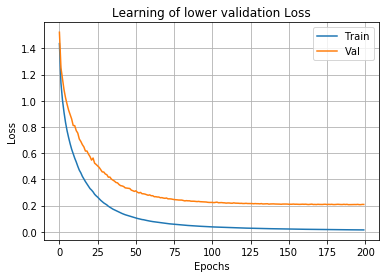

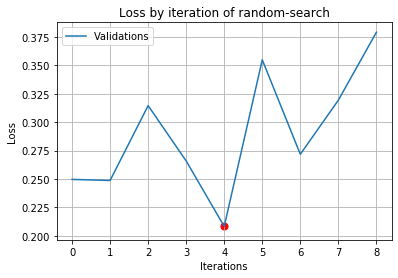

In [101]:
# tamanho do batch, épocas
batch_size = 32
epochs = 200
K = 11 # neurônios de saída
mi = 0.9

# para armazenar a melhor validação de cada combinação do random search
loss_validations = []

# para armazenar as curvas e metricas ao longo do random search
history_loss_val = []
history_loss_train = []
acc_val = []

# seleciona valóres aleatórios para o random search
random_neurons = random.sample(range(50,150), 3)
random_leaning = random.sample(list(np.linspace(0.00001, 0.001, 100)), 3)

# iteração do random search
step=0

start = time.time()

# para cada quantidade de neurônio da lista
for Nh in random_neurons:
    
    
    
    # para cada taxa de aprendizagem da lista
    for alpha in random_leaning:
        
        loss_train = []
        loss_val = []

        # criar rede neural
        net = NeuralNetwork(Nh, X_train_norm.shape[1], alpha, mi, hiddenFunc='tangh', outFunc='softmax')
        
        print(f'Step: {step}')

        # iterações
        for i in range(0, epochs):

            # Permuta dos dados de treino
            indices = np.random.permutation(X_train_norm.shape[0])

            # Percorre todos os elementos em lotes
            for j in range(0,len(indices),batch_size):

                if j+batch_size <= len(X_train_norm):
                    batch_X = X_train_norm[indices[j:j+batch_size],:]
                    batch_y = y_train_encod[indices[j:j+batch_size]]
                else:
                    batch_X = X_train_norm[indices[j:],:]
                    batch_y = y_train_encod[indices[j:]] 

                # forward
                o1 = net.forward(batch_X)

                e = (batch_y - o1)

                # backward
                net.backward(e, batch_X, 'classification')

            #Realiza a predição de validação e cálcula a cross-entropy
            pred_val = net.forward(X_val_norm)

            cross_entropy_val = crossEntropy(y_val_encod, pred_val)
            loss_val.append(cross_entropy_val)
            
            # calcula acurácia de validação
            y_pred_val_class = np.argmax(pred_val, axis=1)
            acc = accuracy(y_val, y_pred_val_class)

            # Realiza predição de treino e cálcula a cross-entropy
            pred_train = net.forward(X_train_norm)

            cross_entropy_train = crossEntropy(y_train_encod, pred_train)
            loss_train.append(cross_entropy_train)
            
        # armazena as informações dessa combinação do random-search
        loss_validations.append(cross_entropy_val) # a validação a ser considerada é a ultima das épocas
        history_loss_train.append(loss_train)
        history_loss_val.append(loss_val)
        acc_val.append(acc)
        step+=1

end = time.time()
print(f'Time: {end - start}')

# Obtem combinação de hiperparâmetros com menor loss de validação
mini = np.min(loss_validations)

index = loss_validations.index(mini)
p_neur = int(index/len(random_neurons))
p_lr = index - int(index/len(random_leaning)) * len(random_leaning)

print(f'\n hyperparameters of lower validation by random-search:\n N: {random_neurons[p_neur]} lr: {random_leaning[p_lr]}\n')

print(f'Accuracy of lower validation set: {acc_val[index]}% \n')

# Plotagem das curvas obtidas com a melhor combinação de hiperparâmetros
plt.plot(range(len(history_loss_train[index])), history_loss_train[index], label='Train')
plt.plot(range(len(history_loss_val[index])), history_loss_val[index], label='Val')
plt.title('Learning of lower validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")   
plt.grid(True)
plt.legend()
plt.show()

# Plotagem dos resultados do random-search
plt.plot(range(len(loss_validations)), loss_validations, label='Validations')
plt.scatter(index, loss_validations[index], s=50, c='red') # marca menor valor
plt.title('Loss by iteration of random-search')
plt.xlabel("Iterations")
plt.ylabel("Loss")   
plt.grid(True)
plt.legend()
plt.show()   

### Retreinamento 
Une os grupos de treino e validação para realizar o treinamento novamento com os melhores hiperparâmetros obtidos no processo anterior. Nesse processo, são calculadas as métricas para o grupo de treino e teste e apresentadas ao final juntos com o de validação de menor cross-entropy da etapa anterior.

In [105]:
# Une os grupos de treino e validação
X_train = np.r_[X_train, X_val]
y_train = np.r_[y_train, y_val]

print(f'Sizes: \nX_train: {len(X_train)} X_test: {len(X_test)} total: {len(X)}')

# obtem as escalas para normalizar e o enconder para transformação one-hot-enconding
X_scale = StandardScaler().fit(X_train)
encoder = OneHotEncoder(sparse=False)

# Normaliza os dados de treino e transforma y
X_train_norm = X_scale.transform(X_train)
y_train_encod = encoder.fit_transform(y_train.reshape(len(y_train), 1))

# Normaliza os dados de teste e transforma y
X_test_norm = X_scale.transform(X_test)
y_test_encod = encoder.fit_transform(y_test.reshape(len(y_test), 1))

# Adiciona coluna de 1
X_train_norm = addOneColunm(X_train_norm)
X_test_norm = addOneColunm(X_test_norm)

Sizes: 
X_train: 990 X_test: 198 total: 990


In [107]:
# realiza o treinamento novamente com os melhores hiperparâmetros obtidos no random-search
W_delta = 0
M_delta = 0

# melhor combinação pelo random-search
Nh = random_neurons[p_neur]
alpha = random_leaning[p_lr]
    
net = NeuralNetwork(Nh, X_train_norm.shape[1], alpha, mi, hiddenFunc='tangh', outFunc='softmax')

# iterações
for i in range(0, 500):

    # Permuta dos dados de treino
    indices = np.random.permutation(X_train_norm.shape[0])

    # Percorre todos os elementos em lotes
    for j in range(0,len(indices),batch_size):

        if j+batch_size <= len(X_train_norm):
            batch_X = X_train_norm[indices[j:j+batch_size],:]
            batch_y = y_train_encod[indices[j:j+batch_size]]
        else:
            batch_X = X_train_norm[indices[j:],:]
            batch_y = y_train_encod[indices[j:]] 

         # forward
        o1 = net.forward(batch_X)

        e = (batch_y - o1)

        # backward
        net.backward(e, batch_X, 'classification')
                            
#Realiza a predição de treino e cálcula a cross-entropy e acurácia
pred_train = net.forward(X_train_norm)
cross_entropy_train = crossEntropy(y_train_encod, pred_train)

y_pred_train_class = np.argmax(pred_train, axis=1)
acc_train = accuracy(y_train, y_pred_train_class)
            
#Realiza a predição de test e cálcula a cross-entropy e acurácia
pred_test = net.forward(X_test_norm)
cross_entropy_test = crossEntropy(y_test_encod, pred_test)

y_pred_test_class = np.argmax(pred_test, axis=1)
acc_test = accuracy(y_test, y_pred_test_class)

print(f'Accuracy of lower validation set from random-search:\nAccuracy: {acc_val[index]}% \n')
print('\n=======================================\n')
print(f'Metrics Train (Val + Train) set:\nAccuracy: {acc_train}%\n')
print('\n=======================================\n')
print(f'Metrics Test set:\nAccuracy: {acc_test}%\n')

Accuracy of lower validation set from random-search:
Accuracy: 93.43434343434343% 



Metrics Train (Val + Train) set:
Accuracy: 100.0%



Metrics Test set:
Accuracy: 98.48484848484848%

